### Состав команды:

- Поляков Александр (Aleksandr Polyakov)
- Востриков Алексей (Alexey Vostrikoff)
- Садыков Динар (Dinar_Sadykow)
- Федотов Андрей (Andrei Fedotov)
- Каштанкина Ксения
- Овчинников Алексей (Aleksey)
- Пьянков Алексей
- Лукошко Роберт (Robert)
- Поперечный Богдан (Bogdan2105)


# Шаг 1. Подготовка данных


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,12)

from ipywidgets import interact, IntSlider, FloatSlider

In [18]:
def age_format(age):
    if 18 <= age <= 24:
        return 1
    elif 25 <= age <= 34:
        return 2
    elif 35 <= age <= 44:
        return 3
    elif 45 <= age <= 54:
        return 4
    elif age >= 55:
        return 5
    else: 
        return 0

In [19]:
df_sample = pd.read_csv('sample_submission.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train.loc[:, 'sample'] = 'train'
df_test.loc[:, 'sample'] = 'test'
df = df_test.append(df_train).reset_index(drop=True)

object_dict = []
for i in df.columns: # перебираем все столбцы
    if (str(df[i].dtype) == 'object') and (i != '_id') and (i != 'sample') : # если тип столбца - object
#         print('='*10)
#         print(i) # выводим название столбца
#         print(set(df[i])) # выводим все его значения (но делаем set - чтоб значения не повторялись)
#         print('\n') # выводим пустую строку
        object_dict.append(i)

/Users/aleksandrpolakov/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [20]:
def preproc_data(df_input):
    df_output = df_input.copy()
    df_output = df_output.drop('_id', axis = 1)
    df_output = pd.get_dummies(df_output, columns=object_dict)
    return df_output

In [21]:
df = preproc_data(df)
df_preproc = df#[df['duration'] > 0]

df_train_preproc = df_preproc.query('sample == "train"').drop(['sample'], axis=1)
df_test_preproc = df_preproc.query('sample == "test"').drop(['sample'], axis=1)

In [22]:
df_y_train = list(df_train_preproc['target'])
df_x_train = df_train_preproc.drop(['target'], axis = 1)
df_y_test = list(df_test_preproc['target']) # здесь неизвестные значения Nan - которые нужно найти
df_x_test = df_test_preproc.drop(['target'], axis = 1) # здесь входные параметры
print('X train ', df_x_train.shape)
print('Y train ', len(df_y_train))
print('X test ',df_x_test.shape)
print('Y test ', len(df_y_train))

X train  (24712, 63)
Y train  24712
X test  (16476, 63)
Y test  24712


# Шаг 2. Проверка 3-х моделей на df_x_train (X_train, X_test) и df_y_train (y_train, y)

In [23]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression  # импортируем модель машинного обучения
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

X_train, X_test, y_train, y = train_test_split(df_x_train, df_y_train, test_size=0.33, random_state=42)
print('X_train ', X_train.shape)
print('X_test ',X_test.shape)

X_train  (16557, 63)
X_test  (8155, 63)


In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

model0 = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

model0.fit(X_train, y_train)

predict = model0.predict(X_test)                      # делаем предсказание
# dict_model ['KNeighborsClassifier']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> KNeighborsClassifier <<<','#'*10,'\n',classification_report(y, predict),'\n')

########## >>> KNeighborsClassifier <<< ########## 
              precision    recall  f1-score   support

        0.0       0.91      0.97      0.94      7230
        1.0       0.58      0.28      0.38       925

avg / total       0.88      0.90      0.88      8155
 



In [25]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.cross_validation import train_test_split

dict_model = {}

model1 = KNeighborsClassifier(n_neighbors=3, weights='uniform', p=2, metric='euclidean')
model1.fit(X_train, y_train)

predict = model1.predict(X_test)                      # делаем предсказание
dict_model ['KNeighborsClassifier']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> KNeighborsClassifier <<<','#'*10,'\n',classification_report(y, predict),'\n')

########## >>> KNeighborsClassifier <<< ########## 
              precision    recall  f1-score   support

        0.0       0.93      0.95      0.94      7230
        1.0       0.56      0.47      0.52       925

avg / total       0.89      0.90      0.89      8155
 



Text(0,0.5,'ROC AUC')

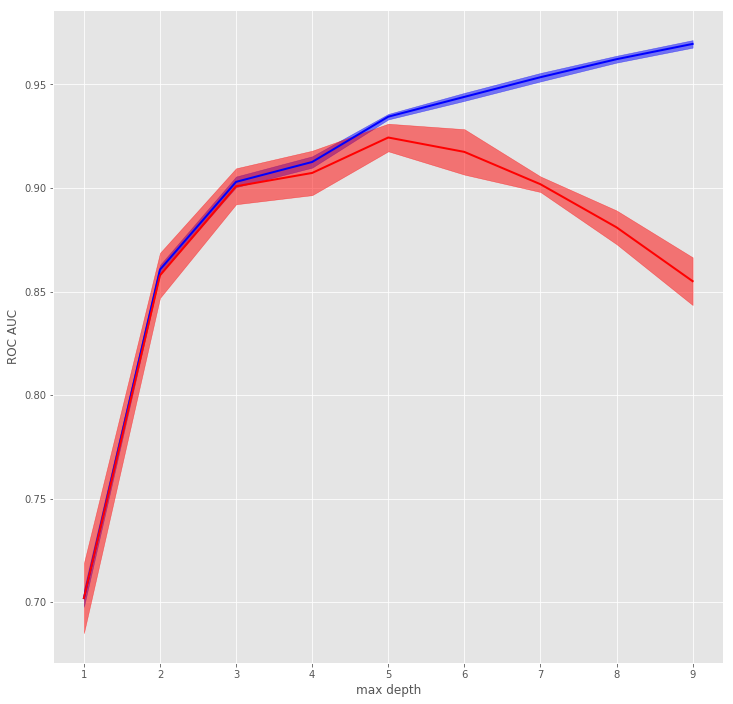

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from ipywidgets import interact, IntSlider
import subprocess

try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

try:
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import StratifiedKFold

# ---------------------------------------------------------------------
# ищем максимальную точность на графике max_depth

model2 = DecisionTreeClassifier(random_state=123)
model2.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=132)
train_scores, valid_scores = validation_curve(model2, X_train, y_train, 
                                              'max_depth', range(1, 10),
                                              cv=cv, scoring='roc_auc')
train_score_mean = train_scores.mean(axis=1)
train_score_std = train_scores.std(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)
valid_scores_std = valid_scores.std(axis=1)

plt.fill_between(range(1,10), train_score_mean-train_score_std, train_score_mean+train_score_std, color='b',
                 interpolate=True, alpha=0.5,)
plt.fill_between(range(1,10), valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='r', 
                 interpolate=True, alpha=0.5)

plt.plot(range(1,10), train_score_mean, c='b', lw=2) #синяя линия обучающая выборка
plt.plot(range(1,10), valid_scores_mean, c='r', lw=2) #красная линяя - валидационная выборка

plt.xlabel('max depth')
plt.ylabel('ROC AUC')

# это значит, что мы будем проверять влияние параметра max_depth
# в дапозоне от 1 до 10
# и для этого мы будем использовать 5-fold кросс-валидацию
# с мерой качества mean_absolute_error.
# neg_ потому что по умолчанию в sklearn чем значение меры выше - тем лучше, 
# но в нашем случае нам нужно как раз допускать меньшую ошибку
# ---------------------------------------------------------------------

In [32]:
depth=6 #видно из графика

model2 = DecisionTreeClassifier(max_depth = depth, random_state=123)
model2.fit(X_train, y_train)

predict = model2.predict(X_test)                      # делаем предсказание
dict_model ['DecisionTreeClassifier']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> DecisionTreeClassifier <<<','#'*10,'\n',classification_report(y, predict),'\n')

########## >>> DecisionTreeClassifier <<< ########## 
              precision    recall  f1-score   support

        0.0       0.94      0.96      0.95      7230
        1.0       0.65      0.54      0.59       925

avg / total       0.91      0.92      0.91      8155
 



In [38]:
model3_1 = LogisticRegression()                     # инициализируем модель
model3_1.fit(X_train, y_train)                      # обучаем модель
predict = model3_1.predict(X_test)                      # делаем предсказание
dict_model ['LogisticRegression']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> LogisticRegression <<<','#'*10,'\n',classification_report(y, predict),'\n')

########## >>> LogisticRegression <<< ########## 
              precision    recall  f1-score   support

        0.0       0.93      0.97      0.95      7230
        1.0       0.68      0.41      0.51       925

avg / total       0.90      0.91      0.90      8155
 



In [39]:
model3_2 = LogisticRegression(class_weight='balanced')                     # инициализируем модель
model3_2.fit(X_train, y_train)                      # обучаем модель
predict = model3_2.predict(X_test)                      # делаем предсказание
dict_model ['LogisticRegression']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> LogisticRegression <<<','#'*10,'\n',classification_report(y, predict),'\n')

########## >>> LogisticRegression <<< ########## 
              precision    recall  f1-score   support

        0.0       0.98      0.86      0.92      7230
        1.0       0.44      0.88      0.59       925

avg / total       0.92      0.86      0.88      8155
 



In [40]:
model3_2_proba = model3_2.predict_proba(X_test )
roc_auc_score(y, model3_2_proba[:, 1])

0.9359002654106389

In [41]:
model3_1_proba = model3_1.predict_proba(X_test )
roc_auc_score(y, model3_1_proba[:, 1])

0.9323062315427461

In [42]:
from scipy.stats import randint as randint
from scipy.stats import uniform

try:
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import GridSearchCV
    from sklearn.cross_validation import RandomizedSearchCV
    from sklearn.cross_validation import StratifiedKFold

# Определим пространство поиска

param_grid = {
    'criterion': ['gini', 'entropy'], #критерии
    'max_depth': randint(2, 8), #максимальная глубина от 2 до 8
    'min_samples_leaf': randint(5, 10), #минимальное количество объектов в вершие дерева, достаточное чтоб дробить дерево на части
    'class_weight': [None, 'balanced']} #объекты классов, которые недопредставлены в выборке, будет взвешивать и балансировать

# Некоторые параметры мы задали не простым перечислением значений, а с помощью распределений.

# Будем делать 200 запусков поиска
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

model4 = DecisionTreeClassifier(random_state=123)
random_search = RandomizedSearchCV(model4, param_distributions=param_grid, n_iter=200, n_jobs=-1,
                                   cv=cv, scoring='roc_auc', random_state=123) #200 переборов, n_jobs=-1 дает параллельное вычисление
# А дальше, просто .fit()
random_search.fit(X_train, y_train)
model4best = random_search.best_estimator_

predict = model4best.predict(X_test)                      # делаем предсказание
dict_model ['DecisionTreeClassifier random_search']= [precision_score(y, predict), recall_score(y, predict), accuracy_score(y, predict)]
print('#'*10,'>>> DecisionTreeClassifier random_search <<<','#'*10,'\n',classification_report(y, predict),'\n')

########## >>> DecisionTreeClassifier random_search <<< ########## 
              precision    recall  f1-score   support

        0.0       0.99      0.83      0.90      7230
        1.0       0.40      0.90      0.56       925

avg / total       0.92      0.84      0.86      8155
 



In [43]:
model4_proba = random_search.predict_proba(X_test )
roc_auc_score(y, model4_proba[:, 1])

0.9296144443198385

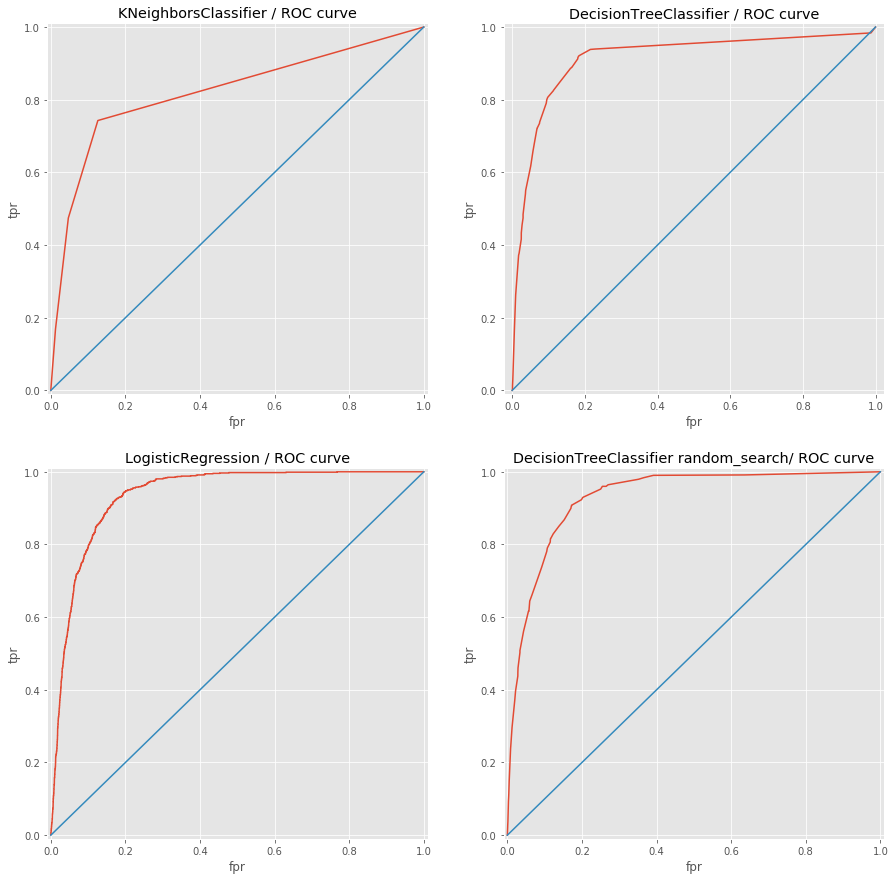

In [44]:
# Потроить roc-кривые всех можелей на одном графике
# Вывести roc_auc каждой моделе
# Подпишите оси и линии

plt.figure(figsize=(15, 15))

#subplot 1
plt.subplot(221)
predict_proba1 = model1.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba1[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('KNeighborsClassifier / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

#subplot 2
plt.subplot(222)
predict_proba2 = model2.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba2[:,1])
plt.plot(fpr, tpr);
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.axis('equal')
plt.grid(True)
plt.title('DecisionTreeClassifier / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

#subplot 3
plt.subplot(223)
predict_proba3_2 = model3_2.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba3_2[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('LogisticRegression / ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))

#subplot 4
plt.subplot(224)
predict_proba3 = model4best.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y, predict_proba3[:,1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('DecisionTreeClassifier random_search/ ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
plt.show()

In [45]:
from sklearn.cross_validation import cross_val_score
# Сделать k-fold (10 фолдов) кросс-валидацию каждой модели
# И посчитать средний roc_auc

cross1 = cross_val_score(model1,df_x_train,df_y_train,scoring='roc_auc', cv=10)
cross2 = cross_val_score(model2,df_x_train,df_y_train,scoring='roc_auc', cv=10)
cross3 = cross_val_score(model3_2,df_x_train,df_y_train,scoring='roc_auc', cv=10)
cross4 = cross_val_score(model4best,df_x_train,df_y_train,scoring='roc_auc', cv=10)

print('#'*10,'>>> AVG roc_auc for Train: <<<','#'*10,
      '\nModel 1. KNeighborsClassifier\t\t\t{:.4f}                   \
      \nModel 2. DecisionTreeClassifier\t\t\t{:.4f}                  \
      \nModel 3. LogisticRegression\t\t\t{:.4f}                      \
      \nModel 4. DecisionTreeClassifier random_search\t{:.4f} '
      .format( (sum(cross1) / float(len(cross1))),
              (sum(cross2) / float(len(cross2))),
              (sum(cross3) / float(len(cross3))),
              (sum(cross4) / float(len(cross4))),
             ) )

########## >>> AVG roc_auc for Train: <<< ########## 
Model 1. KNeighborsClassifier			0.8310                         
Model 2. DecisionTreeClassifier			0.9276                        
Model 3. LogisticRegression			0.9356                            
Model 4. DecisionTreeClassifier random_search	0.9371 


# Шаг 3. По лучшей модели ищем решение df_y_test по df_x_test

In [55]:
predict = model4best.predict(df_x_test)
df_test['target'] = predict
df_test['target'] = df_test['target'].astype('int')
print(list(df_test.columns))

['_id', 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'sample', 'target']


In [56]:
df_result = df_test.drop(['age', 'job', 'marital', 'education', 'default', 'housing',
                          'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign',
                          'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
                          'cons.conf.idx', 'euribor3m', 'nr.employed', 'sample'], axis = 1)
# df_result.head()

In [57]:
df_result.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16476 entries, 0 to 16475
Data columns (total 2 columns):
_id       16476 non-null object
target    16476 non-null int64
dtypes: int64(1), object(1)
memory usage: 257.5+ KB


In [58]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16476 entries, 0 to 16475
Data columns (total 2 columns):
_id       16476 non-null object
target    16476 non-null int64
dtypes: int64(1), object(1)
memory usage: 257.5+ KB


## Шаг 4. Запись результатов в файл 'result_submission.csv'


In [59]:
df_result.to_csv('result_submission.csv', sep=',', encoding='utf-8',index=False)